## setting

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
import torch
import torch.nn as nn
import numpy as np
import sys
sys.path.append("/content/drive/My Drive/LCNN/")

import os
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt



import imp
import importlib
import LCNN
imp.reload(LCNN)
from LCNN import adjust,accuracy,one_hot
device = torch.device('cuda')


Mounted at /content/drive


In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
batchsize=64

trainset = datasets.MNIST('/content/drive/My Drive/data', download=True, train=True, transform=transform)
valset = datasets.MNIST('/content/drive/My Drive/data', download=True, train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=False)
valloader = torch.utils.data.DataLoader(valset, batch_size=batchsize, shuffle=False)

## 4 layer

In [4]:
# Device configuration
device = torch.device('cuda')
# Hyper-parameters 
input_size = 784

hidden_size1 = 800

hidden_size2 = 200

hidden_size3 = 100


num_classes = 10
batch_size = 64


class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3,num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1) 

        
        
        
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2,bias=False)

        
        
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu2 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size3, num_classes,bias=False)


        self.fc1.weight.detach().uniform_(-1, 1)
        self.fc1.bias.detach().uniform_(-1, 1)
        self.fc2.weight.detach().uniform_(-1,1)
        self.fc3.weight.detach().uniform_(-1, 1)
        self.fc3.bias.detach().uniform_(-1, 1)
        self.fc4.weight.detach().uniform_(-1,1)





        self.lsm=nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        out = self.fc1(x)
        out = out/np.sqrt(input_size)
        out = self.relu1(out)
        out = self.fc2(out)
        out = out/np.sqrt(hidden_size1)
        out = self.fc3(out)
        out = out/np.sqrt(hidden_size2)
        out = self.relu2(out)
        out = self.fc4(out)
        out = out/np.sqrt(hidden_size3)
        return out

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


## Original Training

In [ ]:
out=[]
for p in [-1,0,1]:
    print(p)
    learning_rate = 0.05
    torch.manual_seed(0)
    device = torch.device('cuda')
    model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,num_classes).to(device)
    if p>-1:
        ad=True
    else:
        ad=False
    if ad:
        dataiter = iter(train_loader)
        images, labels = dataiter.next()
        images = images.view(images.shape[0], -1)

        adjust(model,images,threshold_u=10,threshold_l=0.1,scale=0.4,ln=1,oflag=1)
        
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
    #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    num_epochs=700
    dev=100
    losslist=[]


    totalloss=[]


    model.fc2.register_forward_hook(get_activation('fc2'))

    count=0
    dd=10
    de=1
    for epoch in range(num_epochs):
        loss_epoch=0
        for i, (images, labels) in enumerate(train_loader):
                        

            images = images.view(images.shape[0], -1).to(device)
            outputs = model(images).to(device)
            

            labels =one_hot(labels,num_classes).to(device)
            loss = criterion(outputs, labels).to(device)
            if count<10:
                print(count,loss.item())

            
            
            
            

            if ad and (p>0):
                if count==dd:
                    with torch.no_grad():
                        output = model(images)
                        adjust(model,activation['fc'+str(2*de)],threshold_u=10,threshold_l=0.1,scale=0.4,ln=2*de+1,oflag=1)  
            
            count=count+1
            
            totalloss.append(loss.item())
            #if epoch<1:
            #    print(count,loss.item())
            loss_epoch=loss_epoch+loss.item()       
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            


                        
                        
            
        loss_epoch=loss_epoch/len(train_loader) 
        losslist.append(loss_epoch)
        
        print ('Epoch [{}/{}], Loss: {:.4f}' .format(epoch+1, num_epochs, loss_epoch))
        if loss_epoch<0.01:
            break
    out.append([losslist,totalloss])
    accuracy(model,valloader)

-1
0 0.11053480207920074
1 0.10940179973840714
2 0.11264876276254654
3 0.10789944976568222
4 0.1113886758685112
5 0.11204105615615845
6 0.11051731556653976
7 0.10991957038640976
8 0.10970921814441681
9 0.11130920797586441
Epoch [1/700], Loss: 0.0945
Epoch [2/700], Loss: 0.0865


In [12]:
Pigrad[0]=torch

tensor(0.)

In [85]:
learning_rate = 0.05
torch.manual_seed(0)
device = torch.device('cuda')
model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,num_classes).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0)
criterion = nn.MSELoss()
#criterion = nn.NLLLoss()
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.view(images.shape[0], -1).to(device)

H=torch.zeros([batch_size,batch_size])
numberparameter=len(model.state_dict())
labels =one_hot(labels,num_classes).to(device)

for i in range(batch_size):
        image=images[i]
        outputs = model(image).to(device)
        label=labels[i].to(device)
        loss = criterion(outputs, label).to(device)
        optimizer.zero_grad()
        loss.backward()
        Pigrad=[]
        pindex=0
        for p in model.parameters():
            Pigrad.append(p.grad.detach())
        for j in range(i):
            image=images[j]
            outputs = model(image).to(device)
            label=labels[j]
            loss = criterion(outputs, label).to(device)
            optimizer.zero_grad()
            loss.backward()
            Pjgrad=[]
            pjndex=0
            for p in model.parameters():
                Pjgrad.append(p.grad.detach())
            with torch.no_grad():
                ij=0
                for iii in range(numberparameter):
                    ij=torch.sum(Pjgrad[iii]*Pigrad[iii])
                H[i][j]=ij
                H[j][i]=ij
        with torch.no_grad():
            ij=0
            for iii in range(numberparameter):
                ij=torch.sum(Pigrad[iii]*Pigrad[iii])
            H[i][i]=ij
eig=torch.eig(H)              
eigenvalue0=eig[0][:,0].cpu().data.detach().numpy()

TypeError: ignored

In [81]:
learning_rate = 1
torch.manual_seed(0)
device = torch.device('cuda')
model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,num_classes).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0)
criterion = nn.MSELoss()

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.view(images.shape[0], -1).to(device)


adjust(model,images,threshold_u=100,threshold_l=0.01,scale=0.4,ln=1,oflag=1)





H=torch.zeros([batch_size,batch_size])
numberparameter=len(model.state_dict())
labels =one_hot(labels,num_classes).to(device)

for i in range(batch_size):
        image=images[i]
        outputs = model(image).to(device)
        label=labels[i].to(device)
        loss = criterion(outputs, label).to(device)
        optimizer.zero_grad()
        loss.backward()
        Pigrad=[]
        pindex=0
        for p in model.parameters():
            Pigrad.append(p.grad.detach())
        for j in range(i):
            image=images[j]
            outputs = model(image).to(device)
            label=labels[j]
            loss = criterion(outputs, label).to(device)
            optimizer.zero_grad()
            loss.backward()
            Pjgrad=[]
            pjndex=0
            for p in model.parameters():
                Pjgrad.append(p.grad.detach())
            with torch.no_grad():
                ij=0
                for iii in range(numberparameter):
                    ij=torch.sum(Pjgrad[iii]*Pigrad[iii])
                H[i][j]=ij
                H[j][i]=ij
        with torch.no_grad():
            ij=0
            for iii in range(numberparameter):
                ij=torch.sum(Pigrad[iii]*Pigrad[iii])
            H[i][i]=ij
eig=torch.eig(H)           
eigenvalue=eig[0][:,0].cpu().data.detach().numpy()

Adjusting Layer 1, Kernel Nodes: 649, Adptive Nodes151
Adjusting Layer 1, Kernel Nodes: 649, Adptive Nodes151
Adjusting Layer 1, Kernel Nodes: 649, Adptive Nodes151
Adjusting Layer 1, Kernel Nodes: 649, Adptive Nodes151


In [23]:
eig=torch.eig(H)

In [38]:
eigenvalue=eig[0][:,0].cpu().data.detach().numpy()

In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


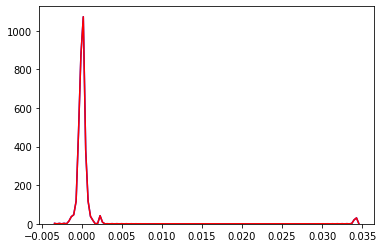

In [82]:
sns.distplot(eigenvalue0, hist=False, rug=False,color='blue');
sns.distplot(eigenvalue, hist=False, rug=False,color='red');

## 2 layers

In [84]:
# Device configuration
device = torch.device('cuda')
# Hyper-parameters 
input_size = 784

hidden_size1 = 800

num_classes = 10
batch_size = 64


class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1,num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1) 

        
        
        
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, num_classes,bias=False)

        


    
    def forward(self, x):
        out = self.fc1(x)
        out = out/np.sqrt(input_size)
        out = self.relu1(out)
        out = self.fc2(out)
        out = out/np.sqrt(hidden_size1)
        return out

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [88]:
learning_rate = 1
torch.manual_seed(0)
device = torch.device('cuda')
model = NeuralNet(input_size, hidden_size1,num_classes).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0)
criterion = nn.MSELoss()
#criterion = nn.NLLLoss()
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.view(images.shape[0], -1).to(device)

H=torch.zeros([batch_size,batch_size])
numberparameter=len(model.state_dict())
labels =one_hot(labels,num_classes).to(device)

for i in range(batch_size):
        image=images[i]
        outputs = model(image).to(device)
        label=labels[i].to(device)
        loss = criterion(outputs, label).to(device)
        optimizer.zero_grad()
        loss.backward()
        Pigrad=[]
        pindex=0
        for p in model.parameters():
            Pigrad.append(p.grad.detach())
        for j in range(i):
            image=images[j]
            outputs = model(image).to(device)
            label=labels[j]
            loss = criterion(outputs, label).to(device)
            optimizer.zero_grad()
            loss.backward()
            Pjgrad=[]
            pjndex=0
            for p in model.parameters():
                Pjgrad.append(p.grad.detach())
            with torch.no_grad():
                ij=0
                for iii in range(numberparameter):
                    ij=torch.sum(Pjgrad[iii]*Pigrad[iii])
                H[i][j]=ij
                H[j][i]=ij
        with torch.no_grad():
            ij=0
            for iii in range(numberparameter):
                ij=torch.sum(Pigrad[iii]*Pigrad[iii])
            H[i][i]=ij
eig0=torch.eig(H)              
eigenvalue0=eig0[0][:,0].cpu().data.detach().numpy()

In [100]:
learning_rate = 1
torch.manual_seed(0)
device = torch.device('cuda')
model = NeuralNet(input_size, hidden_size1,num_classes).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0)
criterion = nn.MSELoss()

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.view(images.shape[0], -1).to(device)


adjust(model,images,threshold_u=100,threshold_l=0.01,scale=0.4,ln=1,oflag=2)





H=torch.zeros([batch_size,batch_size])
numberparameter=len(model.state_dict())
labels =one_hot(labels,num_classes).to(device)

for i in range(batch_size):
        image=images[i]
        outputs = model(image).to(device)
        label=labels[i].to(device)
        loss = criterion(outputs, label).to(device)
        optimizer.zero_grad()
        loss.backward()
        Pigrad=[]
        pindex=0
        for p in model.parameters():
            Pigrad.append(p.grad.detach())
        for j in range(i):
            image=images[j]
            outputs = model(image).to(device)
            label=labels[j]
            loss = criterion(outputs, label).to(device)
            optimizer.zero_grad()
            loss.backward()
            Pjgrad=[]
            pjndex=0
            for p in model.parameters():
                Pjgrad.append(p.grad.detach())
            with torch.no_grad():
                ij=0
                for iii in range(numberparameter):
                    ij=torch.sum(Pjgrad[iii]*Pigrad[iii])
                H[i][j]=ij
                H[j][i]=ij
        with torch.no_grad():
            ij=0
            for iii in range(numberparameter):
                ij=torch.sum(Pigrad[iii]*Pigrad[iii])
            H[i][i]=ij
eig=torch.eig(H)           
eigenvalue=eig[0][:,0].cpu().data.detach().numpy()

tensor([4.5492e-02, 1.5674e-01, 8.4548e-02, 8.4740e-02, 3.1394e-01, 4.4357e-01,
        5.7118e-01, 1.8480e+00, 1.8636e-01, 2.0276e-01, 4.4622e-02, 9.1303e-02,
        7.8356e-02, 6.7274e-02, 5.9182e-02, 3.9780e-02, 3.9208e-02, 6.3942e-02,
        7.5411e-02, 3.4614e-01, 8.1887e-01, 1.4871e-01, 2.6854e-01, 8.6233e-02,
        1.8595e-01, 2.6972e-02, 3.6234e-01, 1.2059e-01, 8.0058e-01, 8.9240e-02,
        9.2105e-02, 5.0475e-02, 2.4632e-01, 4.8315e-02, 2.7584e+00, 5.3276e-02,
        1.4465e-01, 1.3669e-01, 7.6413e-02, 4.5735e-02, 2.1091e-01, 1.1475e+01,
        3.4425e-01, 3.1716e-01, 5.7294e-02, 1.2967e-01, 2.1276e-01, 1.0399e-01,
        6.4561e-02, 3.7278e+00, 1.7510e+00, 8.4621e-02, 1.5385e+00, 1.0464e-01,
        2.1205e+00, 5.7277e-01, 8.9832e-01, 3.7317e+01, 1.3211e-01, 2.3104e+00,
        1.9561e+00, 6.9728e-02, 1.3460e-01, 1.3175e-01, 1.0472e+01, 8.5560e-01,
        2.9871e-02, 4.0687e+01, 2.9208e-01, 2.3755e-01, 1.3980e-01, 6.3788e-01,
        1.1535e-01, 2.1595e+00, 6.6617e-

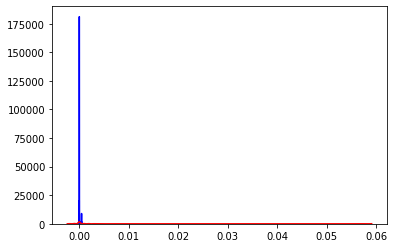

In [102]:
sns.distplot(eigenvalue0, hist=False, rug=False,color='blue');
sns.distplot(eigenvalue, hist=False, rug=False,color='red');

In [94]:
np.max(eigenvalue0)

0.0004562693

In [95]:
np.max(eigenvalue)

0.05885357

In [96]:
np.mean(eigenvalue0)

7.1283516e-06

In [97]:
np.mean(eigenvalue)

0.00092104945

Text(0.5, 0, 'Eigenvalue index')

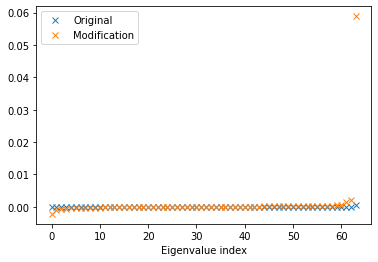

In [106]:
plt.plot(np.sort(eigenvalue0),'x',label='Original')
plt.plot(np.sort(eigenvalue),'x',label='Modification')
plt.legend()
plt.xlabel('Eigenvalue index')